# EvolveGCN Implementation with PyTorch Geometric Temporal

This notebook implements **EvolveGCN** using the standard `torch_geometric_temporal` library.
We compare two variants:
1. **EvolveGCN-O**: Evolves weights based on the previous weight matrix (Trend-Aware).
2. **EvolveGCN-H**: Evolves weights based on the current graph structure (Structure-Aware).

## Prerequisites
Ensure `torch_geometric_temporal` is installed:
`pip install torch_geometric_temporal`

In [23]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import EvolveGCNO, EvolveGCNH
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 1. Data Loading and Preprocessing
Standard Elliptic dataset loading.

In [24]:
print("Loading data...")
# Load Data
classes_df = pd.read_csv("raw_data/elliptic_bitcoin_dataset/elliptic_txs_classes.csv")
edgelist_df = pd.read_csv("raw_data/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")
features_df = pd.read_csv("raw_data/elliptic_bitcoin_dataset/elliptic_txs_features.csv", header=None)

# Rename feature columns
features_df.columns = ['txId', 'time_step'] + [f'feat_{i}' for i in range(165)]

# Map classes: 'unknown'=0, '1'=1 (illicit), '2'=2 (licit)
classes_df['class'] = classes_df['class'].map({'unknown': 0, '1': 1, '2': 2})

# Merge
df = features_df.merge(classes_df, on='txId', how='left')

# Node Mapping
node_ids = df['txId'].values
node_id_to_idx = {node_id: idx for idx, node_id in enumerate(node_ids)}

# Edges
edge_list = []
for _, row in edgelist_df.iterrows():
    if row['txId1'] in node_id_to_idx and row['txId2'] in node_id_to_idx:
        edge_list.append([node_id_to_idx[row['txId1']], node_id_to_idx[row['txId2']]])
edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()

# Tensors
x = torch.tensor(df.iloc[:, 2:-1].values, dtype=torch.float)
y = torch.tensor(df['class'].values, dtype=torch.long)
time_steps = torch.tensor(df['time_step'].values, dtype=torch.long)

print("Data loaded successfully.")

Loading data...
Data loaded successfully.


## 2. Helper Functions

In [25]:
def compute_class_weights(labels):
    n_illicit = (labels == 1).sum().float()
    n_licit = (labels == 2).sum().float()
    total = len(labels)
    
    if n_illicit == 0: weight_illicit = 1.0
    else: weight_illicit = total / (2.0 * n_illicit)
        
    if n_licit == 0: weight_licit = 1.0
    else: weight_licit = total / (2.0 * n_licit)
        
    return torch.tensor([1.0, weight_illicit, weight_licit], dtype=torch.float).to(device)

def get_timestep_data(t, x, y, time_steps, edge_index):
    # Get nodes for timestep t
    mask = (time_steps == t)
    node_indices = torch.where(mask)[0]
    
    # Get features and labels
    x_t = x[mask]
    y_t = y[mask]
    
    # Reindex edges for this subgraph
    # We need edges where BOTH nodes are in the current timestep
    # This is a simplification; EvolveGCN typically handles dynamic graphs where node count changes
    # But we need to map global indices to local indices [0, num_nodes_t]
    
    # Global to Local mapping
    global_to_local = {global_idx.item(): local_idx for local_idx, global_idx in enumerate(node_indices)}
    
    # Filter edges
    mask_edges = torch.isin(edge_index[0], node_indices) & torch.isin(edge_index[1], node_indices)
    edges_t_global = edge_index[:, mask_edges]
    
    # Map to local
    edges_t_local = torch.zeros_like(edges_t_global)
    
    # Fast mapping using tensor operations
    # We can use a sparse matrix or just a lookup array if IDs are contiguous, but they aren't
    # Let's use the map we created
    edges_t_local[0] = torch.tensor([global_to_local[idx.item()] for idx in edges_t_global[0]], device=device)
    edges_t_local[1] = torch.tensor([global_to_local[idx.item()] for idx in edges_t_global[1]], device=device)
    
    return x_t.to(device), edges_t_local.to(device), y_t.to(device)

## 3. EvolveGCN-O Model Definition

In [26]:
class EvolveGCN_O_Model(torch.nn.Module):
    def __init__(self, node_count, in_channels, hidden_channels, out_channels):
        super().__init__()
        # EvolveGCN-O Layer
        self.recurrent = EvolveGCNO(in_channels)
        
        # Linear classifier
        self.linear = torch.nn.Linear(in_channels, out_channels)
        
    def forward(self, x, edge_index, edge_weight=None):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.linear(h)
        return h
    
    def detach_hidden_state(self):
        """Detach the RNN hidden state to prevent backprop through previous timesteps"""
        if hasattr(self.recurrent, 'weight'):
            if self.recurrent.weight is not None:
                self.recurrent.weight = self.recurrent.weight.detach()

## 4. Training Loop (EvolveGCN-O)

In [27]:
# Training Setup with Threshold Filtering and 80-20 Split
ILLICIT_THRESHOLD = 25
valid_timesteps = []
for t in range(1, 50):
    n_illicit = ((time_steps == t) & (y == 1)).sum().item()
    if n_illicit >= ILLICIT_THRESHOLD:
        valid_timesteps.append(t)

print(f"Valid timesteps (>= {ILLICIT_THRESHOLD} illicit txs): {len(valid_timesteps)}")

# 80-20 Temporal Split
split_idx = int(len(valid_timesteps) * 0.80)
train_timesteps = valid_timesteps[:split_idx]
test_timesteps = valid_timesteps[split_idx:]

print(f"Train Timesteps: {train_timesteps}")
print(f"Test Timesteps: {test_timesteps}")

model_o = EvolveGCN_O_Model(
    node_count=x.shape[0], 
    in_channels=x.shape[1], 
    hidden_channels=64, 
    out_channels=3
).to(device)

optimizer = torch.optim.Adam(model_o.parameters(), lr=0.001)

print("Starting EvolveGCN-O Training...")

for epoch in range(50):
    model_o.train()
    total_loss = 0
    
    for t in train_timesteps:
        x_t, edge_index_t, y_t = get_timestep_data(t, x, y, time_steps, edge_index)
        
        # Skip if no edges or nodes (rare but possible)
        if x_t.shape[0] == 0:
            continue
            
        optimizer.zero_grad()
        out = model_o(x_t, edge_index_t)
        
        # Mask for labeled nodes (0 is unknown)
        mask = (y_t > 0)
        if mask.sum() == 0:
            continue
            
        class_weights = compute_class_weights(y_t[mask])
        criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
        
        loss = criterion(out[mask], y_t[mask])
        loss.backward()
        optimizer.step()
        
        # Detach RNN hidden state to prevent backprop through previous timesteps
        model_o.detach_hidden_state()
        
        total_loss += loss.item()
        
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

Valid timesteps (>= 25 illicit txs): 35
Train Timesteps: [4, 7, 8, 9, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 34, 35, 36, 37]
Test Timesteps: [38, 39, 40, 41, 42, 48, 49]
Starting EvolveGCN-O Training...
Epoch 5, Loss: 17.3711
Epoch 10, Loss: 16.9577
Epoch 15, Loss: 16.6936
Epoch 20, Loss: 16.4782
Epoch 25, Loss: 16.4670
Epoch 30, Loss: 16.0883
Epoch 35, Loss: 15.9989
Epoch 40, Loss: 15.9876
Epoch 45, Loss: 16.0309
Epoch 50, Loss: 15.9091


## 5. Evaluation (EvolveGCN-O)

Evaluating EvolveGCN-O...
T38: F1=0.4537
T39: F1=0.2650
T40: F1=0.2787
T41: F1=0.2688
T42: F1=0.4312
T48: F1=0.2936
T49: F1=0.2930


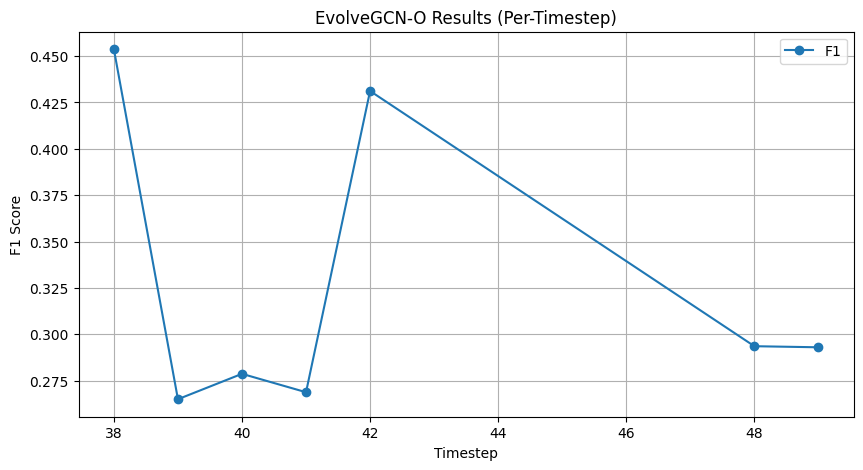


Macro-averaged F1 (mean across timesteps): 0.3263


In [28]:
print("Evaluating EvolveGCN-O...")
model_o.eval()
test_results_o = []

for t in test_timesteps:
    x_t, edge_index_t, y_t = get_timestep_data(t, x, y, time_steps, edge_index)
    
    with torch.no_grad():
        out = model_o(x_t, edge_index_t)
        probs = F.softmax(out, dim=1)
        pred = out.argmax(dim=1)
        
    mask = (y_t > 0)
    if mask.sum() == 0:
        continue
        
    y_true = y_t[mask].cpu().numpy()
    y_pred = pred[mask].cpu().numpy()
    
    # Binary (1=illicit)
    y_true_bin = (y_true == 1).astype(int)
    y_pred_bin = (y_pred == 1).astype(int)
    
    metrics = {
        'timestep': t,
        'f1': f1_score(y_true_bin, y_pred_bin, zero_division=0),
        'recall': recall_score(y_true_bin, y_pred_bin, zero_division=0),
        'precision': precision_score(y_true_bin, y_pred_bin, zero_division=0)
    }
    test_results_o.append(metrics)
    print(f"T{t}: F1={metrics['f1']:.4f}")

# Visualize
res_df_o = pd.DataFrame(test_results_o)
plt.figure(figsize=(10, 5))
plt.plot(res_df_o['timestep'], res_df_o['f1'], marker='o', label='F1')
plt.title('EvolveGCN-O Results (Per-Timestep)')
plt.xlabel('Timestep')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

print(f"\nMacro-averaged F1 (mean across timesteps): {res_df_o['f1'].mean():.4f}")

## 5b. Pooled Evaluation (EvolveGCN-O)

Compute **pooled/micro-averaged** metrics on the combined test set for fair comparison to baseline models.

In [32]:
from sklearn.metrics import roc_auc_score, average_precision_score

print("=" * 80)
print("EVOLVEGCN-O: POOLED TEST SET EVALUATION (MICRO-AVERAGED)")
print("=" * 80)

# Collect all predictions and ground truth for test timesteps
all_y_true = []
all_y_pred = []
all_y_probs = []

model_o.eval()
for t in test_timesteps:
    x_t, edge_index_t, y_t = get_timestep_data(t, x, y, time_steps, edge_index)
    
    with torch.no_grad():
        out = model_o(x_t, edge_index_t)
        probs = F.softmax(out, dim=1)
        pred = out.argmax(dim=1)
    
    mask = (y_t > 0)
    if mask.sum() == 0:
        continue
    
    all_y_true.append(y_t[mask].cpu().numpy())
    all_y_pred.append(pred[mask].cpu().numpy())
    all_y_probs.append(probs[mask][:, 1].cpu().numpy())

# Concatenate all timesteps
y_true_pooled = np.concatenate(all_y_true)
y_pred_pooled = np.concatenate(all_y_pred)
y_probs_pooled = np.concatenate(all_y_probs)

# Binary conversion (1=illicit)
y_true_bin = (y_true_pooled == 1).astype(int)
y_pred_bin = (y_pred_pooled == 1).astype(int)

# Compute pooled metrics
n_total = len(y_true_pooled)
n_illicit = (y_true_pooled == 1).sum()
n_licit = (y_true_pooled == 2).sum()

pooled_metrics_o = {
    'accuracy': accuracy_score(y_true_bin, y_pred_bin),
    'precision': precision_score(y_true_bin, y_pred_bin, zero_division=0),
    'recall': recall_score(y_true_bin, y_pred_bin, zero_division=0),
    'f1': f1_score(y_true_bin, y_pred_bin, zero_division=0),
    'auc_roc': roc_auc_score(y_true_bin, y_probs_pooled) if len(np.unique(y_true_bin)) > 1 else 0.5,
    'auc_pr': average_precision_score(y_true_bin, y_probs_pooled) if len(np.unique(y_true_bin)) > 1 else 0.0
}

print(f"\nPooled Test Set Composition:")
print(f"  Timesteps: {test_timesteps}")
print(f"  Total nodes: {n_total}")
print(f"  Illicit: {n_illicit} ({n_illicit/n_total*100:.2f}%)")
print(f"  Licit: {n_licit} ({n_licit/n_total*100:.2f}%)")

print(f"\n" + "=" * 80)
print("POOLED TEST SET METRICS (for comparison to baseline models)")
print("=" * 80)
print(f"Accuracy:  {pooled_metrics_o['accuracy']*100:.2f}%")
print(f"Precision: {pooled_metrics_o['precision']*100:.2f}%")
print(f"Recall:    {pooled_metrics_o['recall']*100:.2f}%")
print(f"F1 Score:  {pooled_metrics_o['f1']*100:.2f}%")
print(f"AUC-ROC:   {pooled_metrics_o['auc_roc']:.4f}")
print(f"AUC-PR:    {pooled_metrics_o['auc_pr']:.4f}")
print("=" * 80)

print(f"\nComparison:")
print(f"  Macro-averaged (mean of {len(test_timesteps)} timesteps):")
print(f"    F1: {res_df_o['f1'].mean()*100:.2f}%, Precision: {res_df_o['precision'].mean()*100:.2f}%, Recall: {res_df_o['recall'].mean()*100:.2f}%")
print(f"  Micro-averaged (pooled {n_total} nodes):")
print(f"    F1: {pooled_metrics_o['f1']*100:.2f}%, Precision: {pooled_metrics_o['precision']*100:.2f}%, Recall: {pooled_metrics_o['recall']*100:.2f}%")

EVOLVEGCN-O: POOLED TEST SET EVALUATION (MICRO-AVERAGED)

Pooled Test Set Composition:
  Timesteps: [38, 39, 40, 41, 42, 48, 49]
  Total nodes: 7383
  Illicit: 751 (10.17%)
  Licit: 6632 (89.83%)

POOLED TEST SET METRICS (for comparison to baseline models)
Accuracy:  74.54%
Precision: 23.23%
Recall:    65.25%
F1 Score:  34.27%
AUC-ROC:   0.7642
AUC-PR:    0.2029

Comparison:
  Macro-averaged (mean of 7 timesteps):
    F1: 32.63%, Precision: 23.07%, Recall: 59.17%
  Micro-averaged (pooled 7383 nodes):
    F1: 34.27%, Precision: 23.23%, Recall: 65.25%


## 6. EvolveGCN-H Model Definition & Training

In [30]:
class EvolveGCN_H_Model(torch.nn.Module):
    def __init__(self, node_count, in_channels, out_channels):
        super().__init__()
        self.recurrent = EvolveGCNH(node_count, in_channels)
        self.linear = torch.nn.Linear(in_channels, out_channels)
        
    def forward(self, x, edge_index, edge_weight=None):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.linear(h)
        return h
    
    def detach_hidden_state(self):
        """Detach the RNN hidden state to prevent backprop through previous timesteps"""
        # EvolveGCNH stores its weight differently than EvolveGCNO
        # Try multiple possible attribute names
        for attr_name in ['weight', 'initial_weight', '_hidden_weight']:
            if hasattr(self.recurrent, attr_name):
                attr = getattr(self.recurrent, attr_name)
                if attr is not None and isinstance(attr, torch.Tensor):
                    setattr(self.recurrent, attr_name, attr.detach())

model_h = EvolveGCN_H_Model(
    node_count=x.shape[0],
    in_channels=x.shape[1],
    out_channels=3
).to(device)

optimizer_h = torch.optim.Adam(model_h.parameters(), lr=0.001)

print("Starting EvolveGCN-H Training...")

for epoch in range(50):
    model_h.train()
    total_loss = 0
    
    for t in train_timesteps:
        x_t, edge_index_t, y_t = get_timestep_data(t, x, y, time_steps, edge_index)
        
        if x_t.shape[0] == 0:
            continue
            
        optimizer_h.zero_grad()
        
        try:
            out = model_h(x_t, edge_index_t)
        except RuntimeError as e:
            print(f"Error at timestep {t} in epoch {epoch+1}: {e}")
            # Try to continue with next timestep
            continue
        
        mask = (y_t > 0)
        if mask.sum() == 0:
            continue
            
        class_weights = compute_class_weights(y_t[mask])
        criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
        
        loss = criterion(out[mask], y_t[mask])
        loss.backward()
        optimizer_h.step()
        
        # Detach RNN hidden state to prevent backprop through previous timesteps
        model_h.detach_hidden_state()
        
        total_loss += loss.item()
        
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

Starting EvolveGCN-H Training...
Error at timestep 4 in epoch 1: Expected hidden size (1, 5, 165), got [1, 165, 165]
Error at timestep 7 in epoch 1: Expected hidden size (1, 5, 165), got [1, 165, 165]
Error at timestep 8 in epoch 1: Expected hidden size (1, 4, 165), got [1, 165, 165]
Error at timestep 9 in epoch 1: Expected hidden size (1, 5, 165), got [1, 165, 165]
Error at timestep 11 in epoch 1: Expected hidden size (1, 4, 165), got [1, 165, 165]
Error at timestep 13 in epoch 1: Expected hidden size (1, 4, 165), got [1, 165, 165]
Error at timestep 14 in epoch 1: Expected hidden size (1, 2, 165), got [1, 165, 165]
Error at timestep 15 in epoch 1: Expected hidden size (1, 3, 165), got [1, 165, 165]
Error at timestep 16 in epoch 1: Expected hidden size (1, 3, 165), got [1, 165, 165]
Error at timestep 17 in epoch 1: Expected hidden size (1, 3, 165), got [1, 165, 165]
Error at timestep 18 in epoch 1: Expected hidden size (1, 2, 165), got [1, 165, 165]
Error at timestep 19 in epoch 1: Exp

In [31]:
print("Evaluating EvolveGCN-H...")
model_h.eval()
test_results_h = []

for t in test_timesteps:
    x_t, edge_index_t, y_t = get_timestep_data(t, x, y, time_steps, edge_index)
    
    with torch.no_grad():
        out = model_h(x_t, edge_index_t)
        probs = F.softmax(out, dim=1)
        pred = out.argmax(dim=1)
        
    mask = (y_t > 0)
    if mask.sum() == 0:
        continue
        
    y_true = y_t[mask].cpu().numpy()
    y_pred = pred[mask].cpu().numpy()
    
    # Binary (1=illicit)
    y_true_bin = (y_true == 1).astype(int)
    y_pred_bin = (y_pred == 1).astype(int)
    
    metrics = {
        'timestep': t,
        'f1': f1_score(y_true_bin, y_pred_bin, zero_division=0),
        'recall': recall_score(y_true_bin, y_pred_bin, zero_division=0),
        'precision': precision_score(y_true_bin, y_pred_bin, zero_division=0)
    }
    test_results_h.append(metrics)
    print(f"T{t}: F1={metrics['f1']:.4f}")

# Visualize
res_df_h = pd.DataFrame(test_results_h)
plt.figure(figsize=(10, 5))
plt.plot(res_df_h['timestep'], res_df_h['f1'], marker='o', label='F1')
plt.title('EvolveGCN-H Results (Per-Timestep)')
plt.xlabel('Timestep')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

print(f"\nMacro-averaged F1 (mean across timesteps): {res_df_h['f1'].mean():.4f}")

Evaluating EvolveGCN-H...


RuntimeError: Expected hidden size (1, 3, 165), got [1, 165, 165]

In [ ]:
print("=" * 80)
print("EVOLVEGCN-H: POOLED TEST SET EVALUATION (MICRO-AVERAGED)")
print("=" * 80)

# Collect all predictions and ground truth for test timesteps
all_y_true_h = []
all_y_pred_h = []
all_y_probs_h = []

model_h.eval()
for t in test_timesteps:
    x_t, edge_index_t, y_t = get_timestep_data(t, x, y, time_steps, edge_index)
    
    with torch.no_grad():
        out = model_h(x_t, edge_index_t)
        probs = F.softmax(out, dim=1)
        pred = out.argmax(dim=1)
    
    mask = (y_t > 0)
    if mask.sum() == 0:
        continue
    
    all_y_true_h.append(y_t[mask].cpu().numpy())
    all_y_pred_h.append(pred[mask].cpu().numpy())
    all_y_probs_h.append(probs[mask][:, 1].cpu().numpy())

# Concatenate all timesteps
y_true_pooled_h = np.concatenate(all_y_true_h)
y_pred_pooled_h = np.concatenate(all_y_pred_h)
y_probs_pooled_h = np.concatenate(all_y_probs_h)

# Binary conversion (1=illicit)
y_true_bin_h = (y_true_pooled_h == 1).astype(int)
y_pred_bin_h = (y_pred_pooled_h == 1).astype(int)

# Compute pooled metrics
n_total_h = len(y_true_pooled_h)
n_illicit_h = (y_true_pooled_h == 1).sum()
n_licit_h = (y_true_pooled_h == 2).sum()

pooled_metrics_h = {
    'accuracy': accuracy_score(y_true_bin_h, y_pred_bin_h),
    'precision': precision_score(y_true_bin_h, y_pred_bin_h, zero_division=0),
    'recall': recall_score(y_true_bin_h, y_pred_bin_h, zero_division=0),
    'f1': f1_score(y_true_bin_h, y_pred_bin_h, zero_division=0),
    'auc_roc': roc_auc_score(y_true_bin_h, y_probs_pooled_h) if len(np.unique(y_true_bin_h)) > 1 else 0.5,
    'auc_pr': average_precision_score(y_true_bin_h, y_probs_pooled_h) if len(np.unique(y_true_bin_h)) > 1 else 0.0
}

print(f"\nPooled Test Set Composition:")
print(f"  Timesteps: {test_timesteps}")
print(f"  Total nodes: {n_total_h}")
print(f"  Illicit: {n_illicit_h} ({n_illicit_h/n_total_h*100:.2f}%)")
print(f"  Licit: {n_licit_h} ({n_licit_h/n_total_h*100:.2f}%)")

print(f"\n" + "=" * 80)
print("POOLED TEST SET METRICS (for comparison to baseline models)")
print("=" * 80)
print(f"Accuracy:  {pooled_metrics_h['accuracy']*100:.2f}%")
print(f"Precision: {pooled_metrics_h['precision']*100:.2f}%")
print(f"Recall:    {pooled_metrics_h['recall']*100:.2f}%")
print(f"F1 Score:  {pooled_metrics_h['f1']*100:.2f}%")
print(f"AUC-ROC:   {pooled_metrics_h['auc_roc']:.4f}")
print(f"AUC-PR:    {pooled_metrics_h['auc_pr']:.4f}")
print("=" * 80)

print(f"\nComparison:")
print(f"  Macro-averaged (mean of {len(test_timesteps)} timesteps):")
print(f"    F1: {res_df_h['f1'].mean()*100:.2f}%, Precision: {res_df_h['precision'].mean()*100:.2f}%, Recall: {res_df_h['recall'].mean()*100:.2f}%")
print(f"  Micro-averaged (pooled {n_total_h} nodes):")
print(f"    F1: {pooled_metrics_h['f1']*100:.2f}%, Precision: {pooled_metrics_h['precision']*100:.2f}%, Recall: {pooled_metrics_h['recall']*100:.2f}%")